[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Ware_et_al_2025/fig_10.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Ware_et_al_2025/fig_10.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Ware_et_al_2025/fig_10.ipynb)

Fig. 10 from [Ware et al. 2025](https://doi.org/10.48550/arXiv.2509.05536)   
(code below is independent of PySDM, it includes a local implementation of the SDM scheme)

In [1]:
import os, sys
os.environ['NUMBA_THREADING_LAYER'] = 'workqueue'  # PySDM & PyMPDATA don't work with TBB; OpenMP has extra dependencies on macOS
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples', 'PySDM')

In [2]:
from types import SimpleNamespace
import numpy as np
from matplotlib import pyplot
import scipy
from open_atmos_jupyter_utils import show_plot
import networkx as nx

In [3]:
PARAMS_PHYS = SimpleNamespace(
    n0=2**23,
    dv_m3 = 1e6,
    x0_kg=1.192e-13,
    b_per_s = 1500,
)
PARAMS_PHYS.dist = scipy.stats.expon(loc=0, scale=PARAMS_PHYS.x0_kg)
PARAMS_PHYS.norm = PARAMS_PHYS.n0 * PARAMS_PHYS.dv_m3

PARAMS_COMP = SimpleNamespace(
    n_part=2**8,
    n_step = 2,
    t_max_s = 300,
)
PARAMS_COMP.dt_s = PARAMS_COMP.t_max_s / PARAMS_COMP.n_step

PARAMS_BINS = SimpleNamespace(
    min_x = -12,
    max_x = -5,
    count = 70
)

RNG = np.random.default_rng(seed=44)

In [4]:
def sample(*, params_comp, params_phys, rng):
    """ samples a particle population specified onto a grid and returns
    a collection indexed by sampling type, with values composed of `size` and `mult`
    real- and integer-valued arrays, respectively """
    u01 = rng.uniform(0, 1, size=params_comp.n_part)
    x_range =  [params_phys.dist.ppf(q) for q in (.001, .999)]
    uniform_x = x_range[0] + u01 * (x_range[1] - x_range[0])
    uniform_ln_x = np.exp(np.log(x_range[0]) + u01 * (np.log(x_range[1]) - np.log(x_range[0])))
    return {
        key: {
            'mass': val['x'],
            'mult': np.round(val['y'] * params_phys.norm).astype(int),
        }
        for key, val in
        {
            'sampling: uniform random in x': {
                'x': uniform_x,
                'y': params_phys.dist.pdf(uniform_x) * (x_range[1] - x_range[0]) / params_comp.n_part,
            },
            'sampling: uniform random in ln(x)': {
                'x': uniform_ln_x,
                'y': params_phys.dist.pdf(uniform_ln_x) * (np.log(x_range[1]) - np.log(x_range[0])) / params_comp.n_part * uniform_ln_x,
            },
            'sampling: constant multiplicity': {
                'x': params_phys.dist.ppf(u01),
                'y': np.full(shape=params_comp.n_part, fill_value=1 / params_comp.n_part),
            }
        }.items()
    }

PARTICLES = sample(params_phys=PARAMS_PHYS, params_comp=PARAMS_COMP, rng=RNG)

In [5]:
def x_of_mass(mass):
    """ defines the plot x coordinate as a funciton of particle mass """
    return np.log(mass) / 3

def mass_of_x(coord):
    """ computes mass back from the plot x coordinate """
    return np.exp(3 * coord)

def analytic_solution(mass_kg, time_s, params_phys):
    """ Golovin's analytic solution to Smoluchowski coagulation equation 
    for additive kernel and exponential initial condition """
    tau = 1 - np.exp(-params_phys.n0 * params_phys.b_per_s * params_phys.x0_kg * time_s)
    sqrt_tau = np.sqrt(tau)
    return (
        (1 - tau) / (mass_kg * sqrt_tau)
        * scipy.special.ive(1, 2 * mass_kg / params_phys.x0_kg * sqrt_tau)  # pylint: disable=no-member
        * np.exp(-(1 + tau - 2 * sqrt_tau) * mass_kg / params_phys.x0_kg)
    )

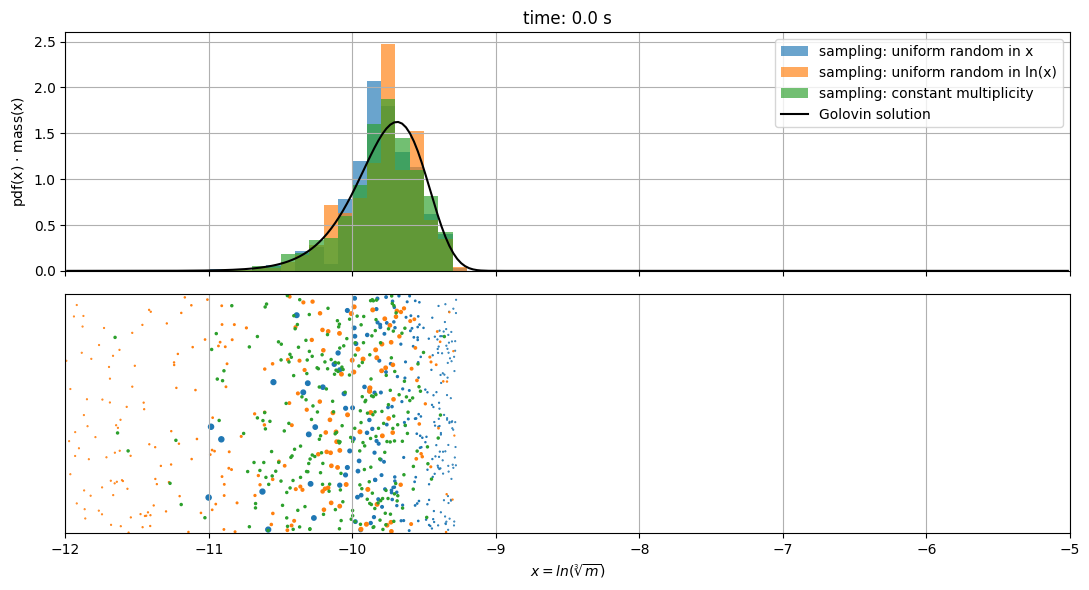

In [6]:
def plot(*, particles, params_phys, params_comp, params_bins, rng, time=0):
    """ plots the particle state as both a histogram as well as population scatter plot
    (with random coordinates shuffled for the purpose of plotting) """
    _, axs = pyplot.subplot_mosaic(
        [['hist'], ['part']],
        figsize=(11, 6),
        sharex=True,
        tight_layout=True,
    )
    for k in particles:
        axs['hist'].hist(
            x=x_of_mass(particles[k]['mass']),
            weights=particles[k]['mult'] / params_phys.norm * particles[k]['mass'],
            bins=params_bins.count,
            range=(params_bins.min_x, params_bins.max_x),
            label=f'{k}',
            alpha=.666,
            density=True,
        )
        axs['part'].scatter(
            x_of_mass(particles[k]['mass']),
            rng.uniform(0, 1, params_comp.n_part),
            s=.25 + 2 * particles[k]['mult'] / (params_phys.norm / params_comp.n_part)
        )
    lin_x, d_x = np.linspace(params_bins.min_x, params_bins.max_x, 256, retstep=True)
    x_mean = lin_x[:-1] + d_x / 2
    m_mean = mass_of_x(x_mean)
    dn_dm = analytic_solution(mass_kg=m_mean, time_s=time, params_phys=params_phys)
    axs['hist'].plot(
        x_mean,
        dn_dm * np.diff(mass_of_x(lin_x)) / np.diff(lin_x) * params_phys.norm * m_mean,
        color='black',
        label='Golovin solution'
    )
    axs['hist'].legend()
    axs['hist'].set_ylabel(r'pdf(x) $\cdot$ mass(x)')
    axs['hist'].set_title(f'time: {time:.1f} s')
    axs['hist'].set_xlim(params_bins.min_x, params_bins.max_x)
    axs['part'].set_xlabel(r'$x = ln(\sqrt[3]{m})$')
    axs['part'].set_yticks([])
    axs['part'].set_ylim(0,1)
    for vl in axs.values():
        vl.grid()
    show_plot(inline_format='png')

plot(particles=PARTICLES, params_phys=PARAMS_PHYS, params_comp=PARAMS_COMP, params_bins=PARAMS_BINS, rng=RNG, time=1e-10)

In [7]:
def coagulate(*, params_phys, params_comp, particles, rng, graphs):
    """ performs Monte-Carlo coagulation of the particles using a simplified SDM algorithm for an additive kernel """
    n_pairs = params_comp.n_part // 2
    p_scale = params_comp.n_part * (params_comp.n_part - 1) / 2 / n_pairs
    for _ in range(params_comp.n_step):        
        non_overlapping_pairs = rng.permutation(params_comp.n_part)[: 2 * n_pairs].reshape(-1, 2)
        u01 = rng.uniform(0, 1, n_pairs)
        for samp,part in particles.items():
            for alpha, pair in enumerate(non_overlapping_pairs):
                j, k = pair
                if part['mult'][j] < part['mult'][k]:
                    j, k = k, j
                kern = params_phys.b_per_s * (part['mass'][j] + part['mass'][k])
                prob = part['mult'][j] * kern * params_comp.dt_s / params_phys.dv_m3

                gamma = np.ceil(prob * p_scale - u01[alpha])
                if gamma != 0:
                    gamma_t = min(gamma, part['mult'][j] // part['mult'][k])
                    deficit = (gamma - gamma_t) * part['mult'][k]
                    graphs[samp].add_edge(
                        j, k, mult_transfer = gamma_t*part['mult'][k],
                        total_mass_transfer = gamma_t*part['mass'][j] * part['mult'][k],
                        mass_transfer = part['mass'][j],
                        total_mass_deficit=deficit * part['mass'][j],
                        size_deficit=deficit*part['mass'][j] / part['mult'][k],
                        mult_deficit=deficit
                    )
                    if part['mult'][j] > gamma_t * part['mult'][k]: 
                        part['mult'][j] -= gamma_t * part['mult'][k]
                        part['mass'][k] += gamma_t * part['mass'][j] 
                    else:
                        part['mult'][j] = part['mult'][k] // 2
                        part['mult'][k] -= part['mult'][k] // 2
                        part['mass'][k] += gamma_t * part['mass'][j]
                        part['mass'][j] = part['mass'][k]

In [8]:
B = {}
for pkey in PARTICLES.keys():
    B[pkey] = nx.DiGraph()
    for i in range(PARAMS_COMP.n_part):
        B[pkey].add_node(i, mass_i=PARTICLES[pkey]['mass'][i], mult_i=PARTICLES[pkey]['mult'][i])

coagulate(particles=PARTICLES, params_comp=PARAMS_COMP, params_phys=PARAMS_PHYS, rng=RNG, graphs = B)

for pkey in PARTICLES.keys():
    for i in range(PARAMS_COMP.n_part):
        B[pkey].nodes[i]['mass_f'] = PARTICLES[pkey]['mass'][i]
        B[pkey].nodes[i]['mult_f'] = PARTICLES[pkey]['mult'][i]

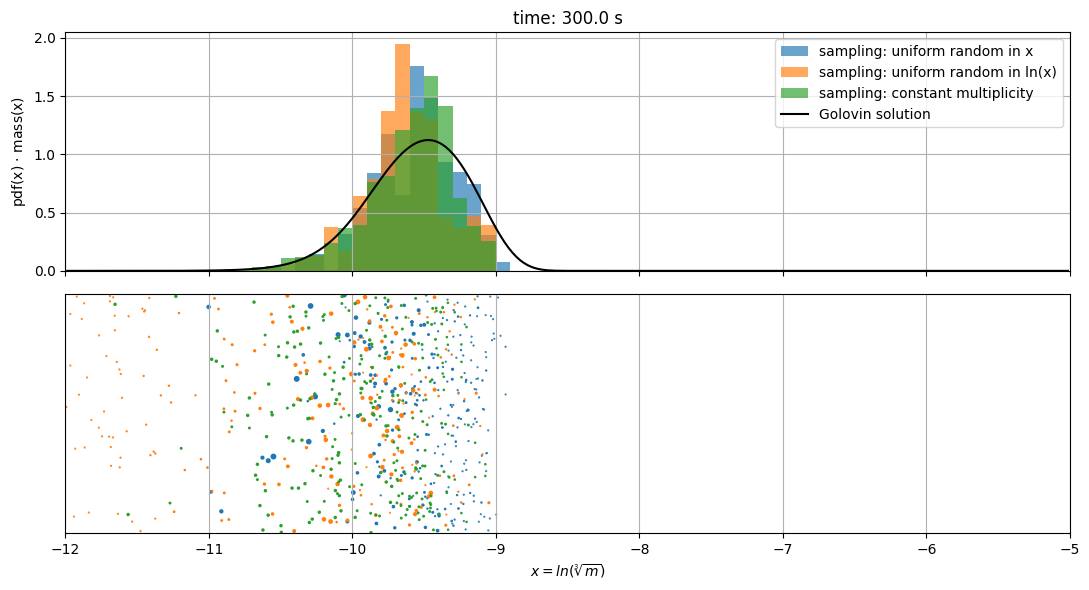

In [9]:
plot(
    particles=PARTICLES,
    params_phys=PARAMS_PHYS,
    params_comp=PARAMS_COMP,
    params_bins=PARAMS_BINS,
    rng=RNG,
    time=PARAMS_COMP.t_max_s,
)

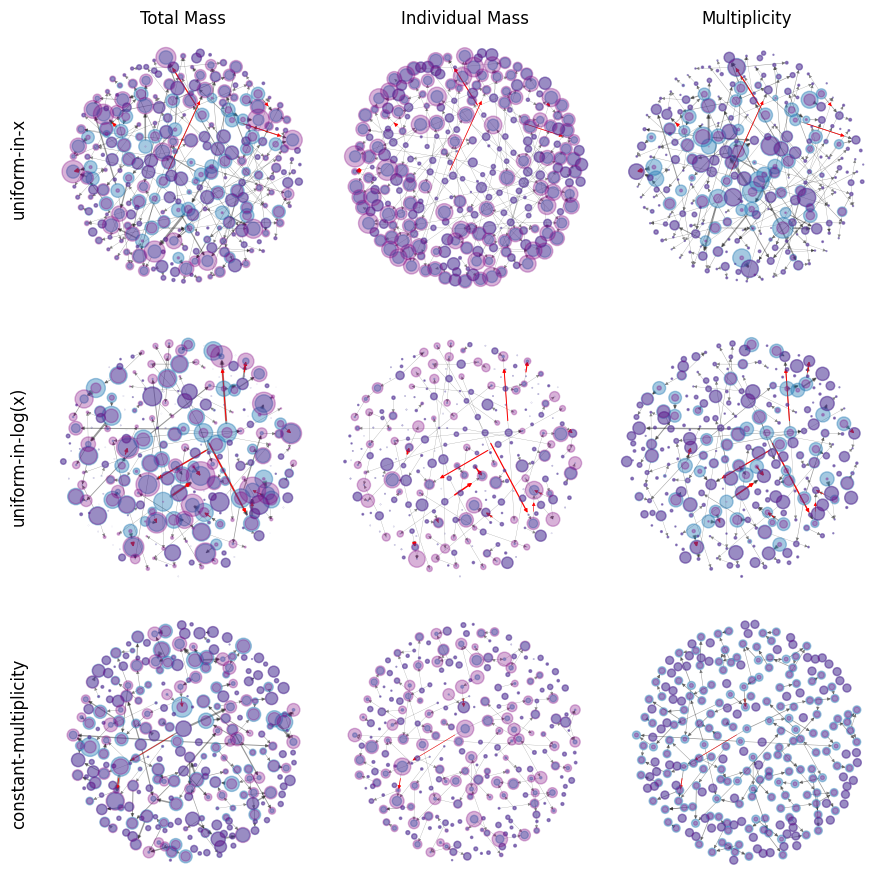

In [10]:
graph_types = ("total_mass", "mass", "mult")

fig, axes = pyplot.subplot_mosaic(
    (
        ['sampling: uniform random in x' + t for t in graph_types],
        ['sampling: uniform random in ln(x)' + t for t in graph_types],
        ['sampling: constant multiplicity' + t for t in graph_types],
    ),
    figsize=(9, 9),
    tight_layout=True,
)
titles = {
    'sampling: uniform random in x': 'uniform-in-x',
    'sampling: uniform random in ln(x)': 'uniform-in-log(x)',
    'sampling: constant multiplicity': 'constant-multiplicity',
    'total_mass': 'Total Mass',
    'mult': 'Multiplicity',
    'mass': 'Individual Mass',
}
for sampling_key, v in B.items():
    pos = nx.forceatlas2_layout(v, scaling_ratio=0.2, strong_gravity=True)
    for graph_type in graph_types:
        ax = axes[sampling_key + graph_type]
        if graph_type == "total_mass":
            attr_i = np.array([v.nodes[i]['mass_i'] * v.nodes[i]['mult_i'] for i in v.nodes])
            attr_f = np.array([v.nodes[i]['mass_f'] * v.nodes[i]['mult_f'] for i in v.nodes])
            scale = 1e4
            scale_edge = 1e2
        else:
            attr_i = np.array([v.nodes[i][graph_type + "_i"] for i in v.nodes])
            attr_f = np.array([v.nodes[i][graph_type + "_f"] for i in v.nodes])
            scale = 1e14 if graph_type == "mass" else 1e-9
            scale_edge = 1e4 if graph_type == "mass" else 1e-11
        nx.draw(v, pos, ax=ax, 
            node_size= scale * attr_i, 
            alpha= 0.4,
            width=[0.2 + scale_edge * v.edges[e][graph_type +'_transfer'] for e in v.edges],
            arrowsize=5,
            with_labels=False
        )
        nx.draw_networkx_edges(
            v,
            pos=pos,
            ax=ax,
            edgelist=[e for e in v.edges if v.edges[e]['mult_deficit']>0],
            edge_color='red',
            width=[0.2 + 1e-11 * v.edges[e]['mult_transfer'] for e in v.edges if v.edges[e]['mult_deficit']>0],
            label='deficit',
            arrowsize=5,
        )
        nx.draw_networkx_nodes(
            v,
            pos,
            ax=ax, 
            node_size= scale * attr_f,
            node_color='purple',
            alpha=0.3,
            label='final size'
        )
        if sampling_key == 'sampling: uniform random in x':
            ax.set_title(titles[graph_type], fontsize=12)
        if graph_type == "total_mass":
            ax.annotate(
                titles[sampling_key],
                xy=(-0.15, 0.5),
                xycoords='axes fraction',
                va='center', 
                fontsize=12,
                rotation=90
            )
show_plot('sdm_network', inline_format='png')